## ExMAS
> Exact Matching of Attractive Shared rides (ExMAS) for system-wide strategic evaluations
> 
> Kucharski R., Cats O. ,_Transportation Research Part: B_, 2020

---

In [2]:
import netwulf as nw

In [3]:
import os
import json
cwd = os.getcwd()

In [4]:
os.chdir(os.path.join(cwd,'../../..'))
import ExMAS.main
import ExMAS.utils

In [5]:
import pandas as pd

In [6]:
from ExMAS.utils import inData as inData
from ExMAS.main import matching

In [7]:
from ExMAS.corona import *

In [8]:
import random
%load_ext autoreload
%autoreload 2

### prepare

1. __load the default config__ (see more details in `ExMAS/notebooks/01 configuration.ipynb`)

In [9]:
params = ExMAS.utils.get_config('ExMAS/data/configs/default.json') # load the default 
params.nP = 3200
#params.simTime = 4

In [10]:
params.corona.participation = 0.65
params.corona.p = 0.8
params.corona.initial_share = 0.002

2. __load the network__ (see more details in `ExMAS/notebooks/02 NetworkGraphs.ipynb`)

In [11]:
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [12]:
inData.logger = init_log(params)  #

3. __generate trip requests__ (see more details in `ExMAS/notebooks/02 NetworkGraphs.ipynb`)

In [14]:
inData.requests = pd.read_csv('ExMAS/data/corona/requests.csv')
inData.sblts.requests = pd.read_csv('ExMAS/data/corona/sblt_requests.csv')
inData.sblts.rides = pd.read_csv('ExMAS/data/corona/rides.csv')
inData.passengers = pd.read_csv('ExMAS/data/corona/passengers.csv')
for col in ['times', 'indexes', 'u_paxes', 'indexes_orig', 'indexes_dest']:
    inData.sblts.rides[col] = inData.sblts.rides[col].apply(lambda x: json.loads(x))
inData.passengers.platforms = inData.passengers.platforms.apply(lambda x: json.loads(x))

In [15]:
inData = make_population(inData, params)

In [16]:
def active_today(inData, params):
    active_ones = inData.passengers[(inData.passengers.active == True)]
    active_ones = active_ones.sample(int(active_ones.shape[0] * params.corona.p))  # those are active today
    active_ones = active_ones[active_ones.state != 'Q']  # except those quarantined
    inData.passengers['active_today'] = False
    inData.passengers['active_today'].loc[
        active_ones.index] = True  # those will be matched and then may be infected

    # if platform is [-1] passenger is not matched
    inData.passengers['platforms'] = inData.passengers.apply(lambda x: [0] if x.active_today else [-1], axis=1)
    inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0],
                                                        axis=1)
    inData.sblts.requests['platform'] = inData.requests['platform']
    return inData
inData = active_today(inData, params)

In [17]:
inData.sblts.rides['platform'] = inData.sblts.rides.apply(lambda row: list(set(inData.requests.loc[row.indexes].platform.values)),
                                        axis=1)

inData.sblts.rides['platform'] = inData.sblts.rides.platform.apply(lambda x: -2 if len(x) > 1 else x[0])

In [18]:
inData = matching(inData, params)

03-01-21 22:20:23-INFO-Matching 3200 trips to 8196 rides in order to min u_veh
03-01-21 22:20:39-INFO-Problem solution: Optimal. 
Total costs for single trips:      1,745,236 
reduced by matching to:            1,447,381


In [19]:
G = ExMAS.utils.make_shareability_graph(inData.sblts.requests[inData.sblts.requests.platform == 0], 
                           inData.sblts.rides[inData.sblts.rides.platform >-2])

In [31]:
config = {'zoom': 0.6966768692610407,
 'node_charge': -45,
 'node_gravity': 0.1,
 'link_distance': 15,
 'link_distance_variation': 0,
 'node_collision': True,
 'wiggle_nodes': False,
 'freeze_nodes': False,
 'node_fill_color': '#000000',
 'node_stroke_color': '#555555',
 'node_label_color': '#000000',
 'display_node_labels': False,
 'scale_node_size_by_strength': True,
 'node_size': 35.0295146480105,
 'node_stroke_width': 1,
 'node_size_variation': 1.0733493659816353,
 'link_color': '#7c7c7c',
 'link_width': 2,
 'link_alpha': 0.5,
 'link_width_variation': 0.5,
 'display_singleton_nodes': True,
 'min_link_weight_percentile': 0,
 'max_link_weight_percentile': 1}

In [23]:
stylized_network, config = nw.visualize(G, config = config)

In [24]:
G_small = ExMAS.utils.make_shareability_graph(inData.sblts.requests[inData.sblts.requests.platform == 0], 
                           inData.sblts.schedule)

In [34]:
config = {'zoom': 0.8546310397341825,
 'node_charge': -45,
 'node_gravity': 0.5983663297798698,
 'link_distance': 12.27275370344732,
 'link_distance_variation': 0,
 'node_collision': True,
 'wiggle_nodes': False,
 'freeze_nodes': False,
 'node_fill_color': '#000000',
 'node_stroke_color': '#555555',
 'node_label_color': '#000000',
 'display_node_labels': False,
 'scale_node_size_by_strength': False,
 'node_size': 3.3365637546725737,
 'node_stroke_width': 1,
 'node_size_variation': 1.0733493659816353,
 'link_color': '#000000',
 'link_width': 4.934289076560986,
 'link_alpha': 1,
 'link_width_variation': 0.5,
 'display_singleton_nodes': True,
 'min_link_weight_percentile': 0,
 'max_link_weight_percentile': 1}

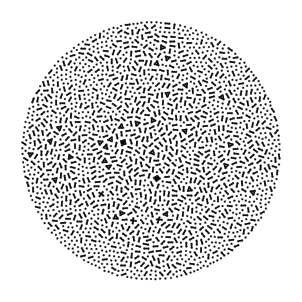

In [32]:
stylized_network, config = nw.visualize(G_small, config = config)

In [ ]:
def degrees(inData, params):
    ret = list()
    for repl in range(10):
        for p in [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 1]:  
            params.corona.p = p
            inData = make_population(inData,params)
            for day in range(100):
                inData = active_today(inData, params)
                inData.sblts.rides['platform'] = inData.sblts.rides.apply(lambda row: list(set(inData.requests.loc[row.indexes].platform.values)),
                                                axis=1)

                inData.sblts.rides['platform'] = inData.sblts.rides.platform.apply(lambda x: -2 if len(x) > 1 else x[0])
                G_today = ExMAS.utils.make_graph(inData.sblts.requests[inData.sblts.requests.platform == 0], 
                                   inData.sblts.rides[inData.sblts.rides.platform >-2])
                if day == 0:
                    G = G_today
                else:
                    G = nx.compose(G, G_today)
                degree = pd.Series([G.degree(n) for n in G.nodes()])
                ret.append({'repl':repl, 'p':p,'day':day, 'mean':degree.mean(),'std':degree.std()})
    pd.DataFrame(ret).to_csv('degrees.csv')
degrees(inData, params)          

In [ ]:
pd.DataFrame(ret).to_csv('degrees.csv')

In [ ]:
params.logger_level = 'INFO'
params.matching_obj = 'u_veh'
params.without_matching = True
params.multi_platform_matching = True

In [ ]:
import networkx as nx
import math
import pandas as pd

### run

In [ ]:
inData = ExMAS.main(inData, params)

In [ ]:
params.corona.participation = 0.625
params.corona.p = 1
inData = make_population(inData,params)
inData.passengers.shape[0], inData.passengers.active.sum(), inData.passengers.active_today.sum() , inData.passengers.groupby('state').size()

In [ ]:
for p in [0.6, 0.8, 0.9]:
    params.p = p
    share_of_active = params.participation / params.p
    inData.passengers['active'] = False
    inData.passengers.active.loc[inData.requests.sample(int(share_of_active*params.nP)).index] = True
    for day in range(1,10):
        print(p, day)
        inData.passengers['active_today'] = inData.passengers.apply(lambda x : is_active_today(x), axis = 1)
        inData.passengers['platforms'] = inData.passengers.apply(lambda x : [0] if x.active_today else [-1], axis = 1)
        inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis=1)
        inData.sblts.requests['platform'] = inData.requests['platform']
        inData = matching(inData, params)        
        G = ExMAS.utils.make_graph(inData.sblts.requests[inData.sblts.requests.platform == 0], inData.sblts.schedule, mu = 0.5, plot = False, node_size = 1)
        nx.write_edgelist(G, 'ExMAS/spinoffs/edgelists/matching_p{}_day{}.csv'.format(params.p, day), delimiter = ',', data = False)
        G = ExMAS.utils.make_graph(inData.sblts.requests[inData.sblts.requests.platform == 0], inData.sblts.rides, mu = 0.5, plot = False, node_size = 1)
        nx.write_edgelist(G, 'ExMAS/spinoffs/edgelists/potential_p{}_day{}.csv'.format(params.p, day), delimiter = ',', data = False)